# Testing Gradient Updates for Demographic Stochasticity
When running the model with arbitrarily chosen stochasticities, we find that egg hatch times are happening too soon. Here, we aim to build up a method for updating stochasticity parameters using gradient descent in a way that can work with current memory constraints.

In [1]:
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import SpongyMothIPM.meteorology as met
from SpongyMothIPM.config import Config
import SpongyMothIPM.util as util
import SpongyMothIPM.kernels as kernels
import SpongyMothIPM.visualization as viz

## Load Weather Data

In [2]:
df = met.load_daymet_data('../data/mont_st_hilaire/mont_st_hilaire_1980_1991.csv')
low_time = 1
high_time = 13
sample_period = 4
sample_start_time = 1
temps = met.daymet_to_diurnal(df, 
                            low_time, 
                            high_time, 
                            sample_period, 
                            sample_start_time)


config = Config(dtype=torch.float,
                delta_t=sample_period/24)

days = len(temps)//(24//sample_period)
learning_rate = 0.00000001

## Model Setup

In [ ]:
class SimpleModel():
    def __init__(self):
        # Build life stages
        self.prediapause = kernels.Prediapause(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/prediapause.csv')
        self.diapause = kernels.Diapause(
            config, n_bins_I=50, n_bins_D=50, save=True, save_rate=1, mortality=0, sigma_I=1, sigma_D=1,
            file_path='../outputs/mont_st_hilaire/diapause.csv')
        self.postdiapause = kernels.Postdiapause(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/postdiapause.csv')
        self.first_instar = kernels.FirstInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1, 
            file_path='../outputs/mont_st_hilaire/first_instar.csv')
        self.second_instar = kernels.SecondInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/second_instar.csv')
        self.third_instar = kernels.ThirdInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/third_instar.csv')
        self.fourth_instar = kernels.FourthInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/fourth_instar.csv')
        self.male_late_instar = kernels.MaleFifthInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/male_late_instar.csv')
        self.female_late_instar = kernels.FemaleFifthSixthInstar(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/female_late_instar.csv')
        self.male_pupae = kernels.MalePupae(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/male_pupae.csv')
        self.female_pupae = kernels.FemalePupae(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/female_pupae.csv')
        self.adults = kernels.Adult(
            config, save=True, save_rate=1, mortality=0, sigma=0.1,
            file_path='../outputs/mont_st_hilaire/adult.csv')
        
        # Gather parameters together for optimization.
        self.parameters = [self.prediapause.sigma,
                           self.diapause.sigma_D,
                           self.diapause.sigma_I,
                           self.postdiapause.sigma,
                           self.first_instar.sigma,
                           self.second_instar.sigma,
                           self.third_instar.sigma,
                           self.fourth_instar.sigma,
                           self.male_late_instar.sigma,
                           self.female_late_instar.sigma,
                           self.male_pupae.sigma,
                           self.female_pupae.sigma,
                           self.adults.sigma]
        
    def init_pop(self):
        # Initiate populations
        mu = 0.2
        sigma = 1.1
        total = 1
        empty = 0
        self.prediapause.init_pop(empty, mu, sigma)
        # Individuals all begin in the prediapause stage at the same time.
        self.prediapause.add_transfers(total) 
        self.diapause.init_pop(empty, mu, sigma)
        self.postdiapause.init_pop(empty, mu, sigma)
        self.first_instar.init_pop(empty, mu, sigma)
        self.second_instar.init_pop(empty, mu, sigma)
        self.third_instar.init_pop(empty, mu, sigma)
        self.fourth_instar.init_pop(empty, mu, sigma)
        self.male_late_instar.init_pop(empty, mu, sigma)
        self.female_late_instar.init_pop(empty, mu, sigma)
        self.male_pupae.init_pop(empty, mu, sigma)
        self.female_pupae.init_pop(empty, mu, sigma)
        self.adults.init_pop(empty, mu, sigma)
    
    def run_one_time_step(self, 
                          year, 
                          doy, 
                          doy_temps,
                          record_start_year, 
                          record_start_doy,
                          record_end_year,
                          record_end_doy,
                          save):
        transfers = self.prediapause.run_one_step(doy_temps)
        transfers = self.diapause.run_one_step(doy_temps, transfers)
        transfers = self.postdiapause.run_one_step(doy_temps, transfers)

        # Record transfers to first instars
        # if record_start_year <= year <= record_end_year: 
        #     if record_start_doy <= doy <= record_end_doy:
        #         if save and not self.first_instar.save:
        #             self.first_instar.save = True
        #         self.hatched[year].append(transfers)
        #     else:
        #         self.first_instar.save = False

        transfers = self.first_instar.run_one_step(doy_temps, transfers)
        transfers = self.second_instar.run_one_step(doy_temps, transfers)
        transfers = self.third_instar.run_one_step(doy_temps, transfers)
        transfers_dif = self.fourth_instar.run_one_step(doy_temps, transfers)
        transfers = self.male_late_instar.run_one_step(doy_temps, transfers_dif/2)
        to_adult = self.male_pupae.run_one_step(doy_temps, transfers)
        transfers = self.female_late_instar.run_one_step(doy_temps, transfers_dif/2)
        to_adult += self.female_pupae.run_one_step(doy_temps, transfers)
        transfers = self.adults.run_one_step(doy_temps, to_adult)
        self.prediapause.add_transfers(transfers/2)

    def forward(self, 
                start_doy,
                record_start_year, 
                record_start_doy,
                record_end_year,
                record_end_doy,
                save):
        # Run Model
        start_year = temps['year'].min()
        end_year = temps['year'].max()
        start = (24//sample_period)*(start_doy-1)
        # For tracking emerging eggs
        self.hatched = {year:[] 
                        for year in range(record_start_year, 
                                          record_end_year+1)}
        for year in range(start_year, end_year+1):
            #print(f"Starting year {year}")
            days = temps.loc[temps['year'] == year, 'yday'].max()
            if year > start_year:
                start_doy = 1
            for doy in range(start_doy, days+1):
                end = start + (24//sample_period)
                doy_temps = temps.iloc[start:end]
                if not (record_start_year <= year <= record_end_year):
                    # While we are not in the year of interest, we will not bother
                    # tracking gradients as it is very memory intensive.
                    with torch.no_grad():
                        self.run_one_time_step(year, 
                                              doy, 
                                              doy_temps,
                                              record_start_year, 
                                              record_start_doy,
                                              record_end_year,
                                              record_end_doy,
                                              save)
                else:
                    self.run_one_time_step(year, 
                                          doy, 
                                          doy_temps,
                                          record_start_year, 
                                          record_start_doy,
                                          record_end_year,
                                          record_end_doy,
                                          save)
                start = end

    def print_params(self):
        print('Prediapause: ', self.prediapause.sigma, self.prediapause.sigma.grad)
        print('Diapause I: ', self.diapause.sigma_I, self.diapause.sigma_I.grad)
        print('Diapause D: ', self.diapause.sigma_D, self.diapause.sigma_D.grad)
        print('Postdiapause: ', self.postdiapause.sigma, self.postdiapause.sigma.grad)
        print('First Instar: ', self.first_instar.sigma, self.first_instar.sigma.grad)
        print('Second Instar: ', self.second_instar.sigma, self.second_instar.sigma.grad)
        print('Third Instar: ', self.third_instar.sigma, self.third_instar.sigma.grad)
        print('Fourth Instar: ', self.fourth_instar.sigma, self.fourth_instar.sigma.grad)
        print('Male Late Instar: ', self.male_late_instar.sigma, self.male_late_instar.sigma.grad)
        print('Female Late Instar: ', self.female_late_instar.sigma, self.female_late_instar.sigma.grad)
        print('Male Pupae: ', self.male_pupae.sigma, self.male_pupae.sigma.grad)
        print('Female Pupae: ', self.female_pupae.sigma, self.female_pupae.sigma.grad)
        print('Adult: ', self.adults.sigma, self.adults.sigma.grad)

    def compute_gradients(self, validation, year, verbose=False):
        # Create a tensor with the relative abundances at each time point.
        self.cum_hatched = [0]*len(self.hatched[year])
        self.cum_hatched[0] = self.hatched[year][0]
        for i in range(1, len(self.hatched[year])):
            self.cum_hatched[i] = self.cum_hatched[i-1] + self.hatched[year][i]
        self.cum_hatched = torch.stack(self.cum_hatched)

        # Compute loss and gradients
        loss = torch.mean((self.cum_hatched - validation)**2)
        print('Loss: ', loss.item())
        loss.backward()

    def update_params(self, validation, year, verbose=False):
        self.compute_gradients(validation, year)

        # Use gradients to update trainable parameters
        with torch.no_grad():
            if verbose:
                self.print_params()
            # Prediapause
            self.prediapause.sigma -= self.prediapause.sigma.grad * learning_rate
            self.prediapause.sigma.grad.data.zero_()
            # Diapause
            self.diapause.sigma_I -= self.diapause.sigma_I.grad * learning_rate
            self.diapause.sigma_I.grad.data.zero_()
            self.diapause.sigma_D -= self.diapause.sigma_D.grad * learning_rate
            self.diapause.sigma_D.grad.data.zero_()
            # Postdiapause
            self.postdiapause.sigma -= self.postdiapause.sigma.grad * learning_rate
            self.postdiapause.sigma.grad.data.zero_()
            # First Instar
            self.first_instar.sigma -= self.first_instar.sigma.grad * learning_rate
            self.first_instar.sigma.grad.data.zero_()
            # Second Instar
            self.second_instar.sigma -= self.second_instar.sigma.grad * learning_rate
            self.second_instar.sigma.grad.data.zero_()
            # Thrid Instar
            self.third_instar.sigma -= self.third_instar.sigma.grad * learning_rate
            self.third_instar.sigma.grad.data.zero_()
            # Fourth Instar
            self.fourth_instar.sigma -= self.fourth_instar.sigma.grad * learning_rate
            self.fourth_instar.sigma.grad.data.zero_()
            # Male Fifth Instar
            self.male_late_instar.sigma -= self.male_late_instar.sigma.grad * learning_rate
            self.male_late_instar.sigma.grad.data.zero_()
            # Female Fifth/Sixth Instar
            self.female_late_instar.sigma -= self.female_late_instar.sigma.grad * learning_rate
            self.female_late_instar.sigma.grad.data.zero_()
            # Male Pupae
            self.male_pupae.sigma -= self.male_pupae.sigma.grad * learning_rate
            self.male_pupae.sigma.grad.data.zero_()
            # Female Pupae
            self.female_pupae.sigma -= self.female_pupae.sigma.grad * learning_rate
            self.female_pupae.sigma.grad.data.zero_()
            # Adults
            self.adults.sigma -= self.adults.sigma.grad * learning_rate
            self.adults.sigma.grad.data.zero_()


In [6]:
model = SimpleModel()
model.init_pop()
model.forward(250, 1980, 0, 1990, 365, True)

In [4]:
def plot_match(model):
    fig, ax1 = plt.subplots()
    hatched = torch.stack(model.hatched[1988]).detach().numpy()
    cum_hatched = np.cumsum(hatched)
    ln1 = ax1.plot(range(0, 365), hatched, color='purple', label='Daily Hatch Rate')
    ln2 = ax1.plot(range(0, 365), cum_hatched, color='purple', linestyle='dashed', label='Cum Hatched')
    ax1.set_ylabel('Modelled', fontsize=20)
    ax1.set_xlabel('Day of Year', fontsize=20)
    ax1.tick_params(labelsize=15)

    ax2 = ax1.twinx()
    ln3 = ax2.plot(range(0, 365), validation, color='black', label='Prop. Hatched')
    ax2.set_ylabel('Observed', fontsize=20)
    ax2.tick_params(labelsize=15)
    
    # Add legend
    lns = ln1 + ln2 + ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    fig.show()

### Test Adam optimizer

In [5]:
def run_adam(model, lr, num_iters, validation, year, verbose=False):
    optim = torch.optim.Adam(model.parameters, lr=lr)

    for i in range(num_iters):
        model.init_pop()
        model.forward(300, 1988, 0, 1990, 365, False)
        model.compute_gradients(validation, year, verbose)
        if verbose:
            plot_match(model)
        optim.step()
        optim.zero_grad()

## Test influence of initial conditions

In [6]:
# Test impact of start date
for i in range(260, 320, 10):
    print("Running model with initial day of ", i)
    model = SimpleModel()
    model.first_instar.file_path = f'../outputs/mont_st_hilaire/first_instar_doy_{i}.csv'
    model.init_pop()
    model.forward(i, 1988, 100, 1990, 200)

Running model with initial day of  260


TypeError: SimpleModel.forward() missing 1 required positional argument: 'save'

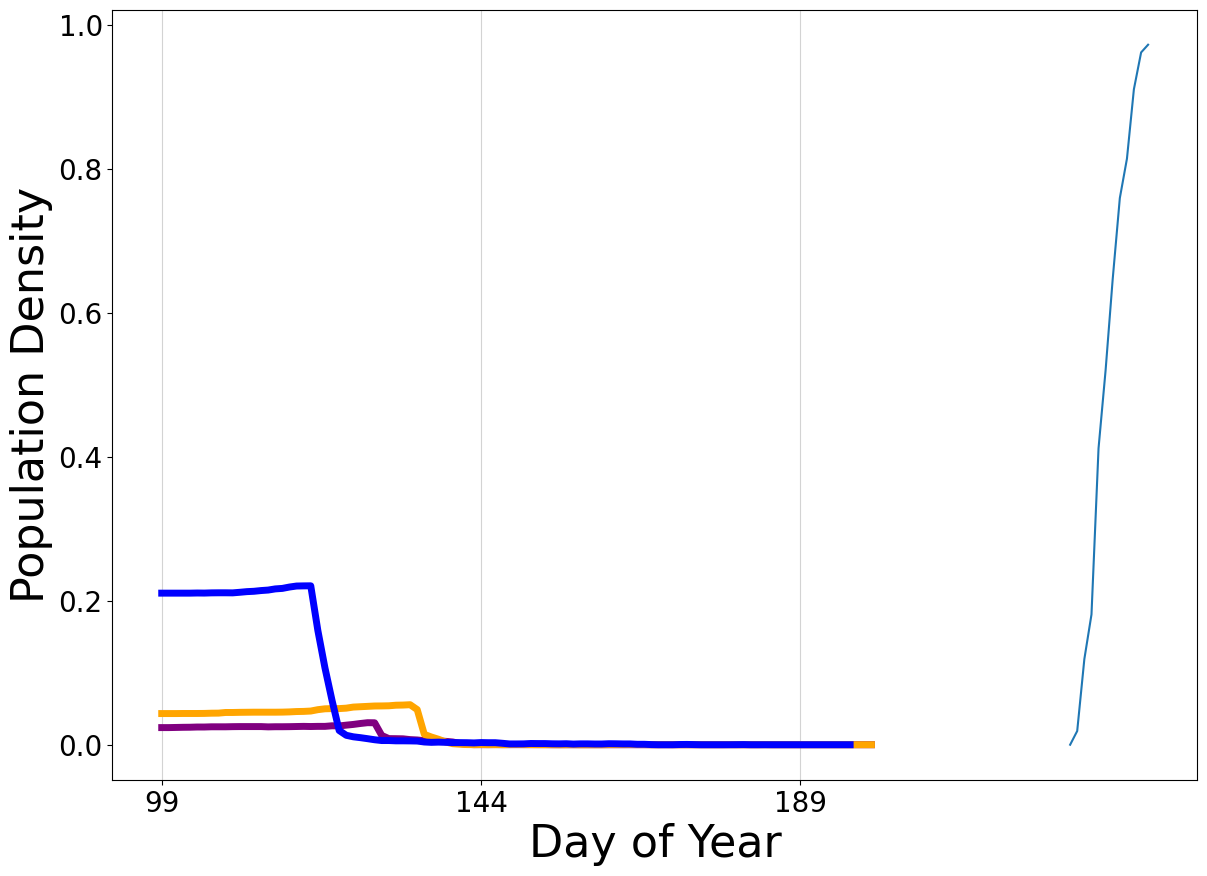

In [39]:
df = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_280.csv', header=0, index_col=[0,1])
dfs = [df[df.index.get_level_values('year') == 1988], 
       df[df.index.get_level_values('year') == 1989], 
       df[df.index.get_level_values('year') == 1990]]
names = ['1988', '1989', '1990']
styles = [{'color':'purple', 'linestyle':'solid', 'linewidth':5},
          {'color':'orange', 'linestyle':'solid', 'linewidth':5},
          {'color':'blue', 'linestyle':'solid', 'linewidth':5}]
validation = pd.read_csv('../data/mont_st_hilaire/hilaire_88.csv')

fig, ax = plt.subplots(figsize=(14, 10))

viz.plot_abundances(ax, dfs, names, styles, validation, tick_freq=45, label_fontsize=32)

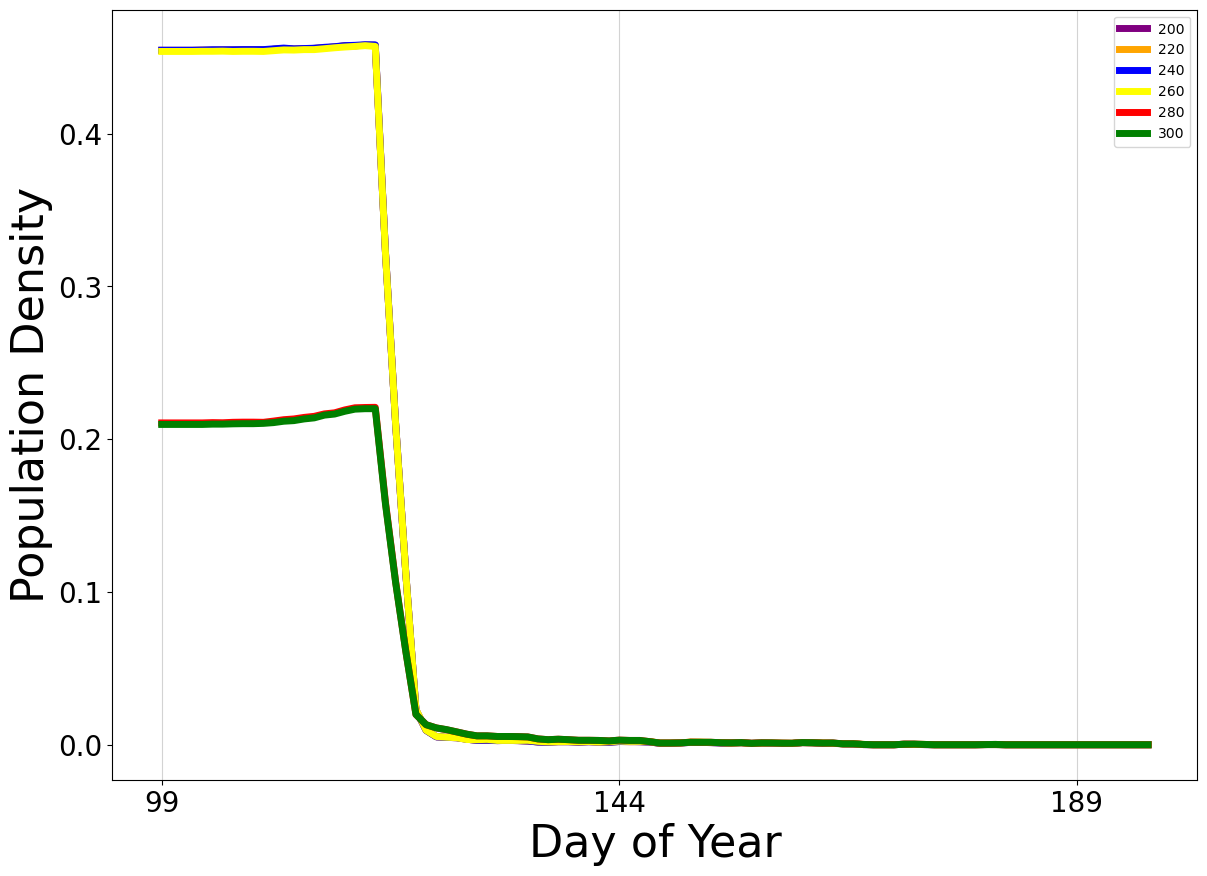

In [45]:
df_200 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_200.csv', header=0, index_col=[0,1])
df_220 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_220.csv', header=0, index_col=[0,1])
df_240 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_240.csv', header=0, index_col=[0,1])
df_260 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_260.csv', header=0, index_col=[0,1])
df_280 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_280.csv', header=0, index_col=[0,1])
df_300 = pd.read_csv('../outputs/mont_st_hilaire/first_instar_doy_300.csv', header=0, index_col=[0,1])
year = 1990
dfs = [df_200[df_200.index.get_level_values('year') == year], 
       df_220[df_220.index.get_level_values('year') == year], 
       df_240[df_240.index.get_level_values('year') == year],
       df_260[df_260.index.get_level_values('year') == year],
       df_280[df_280.index.get_level_values('year') == year],
       df_300[df_300.index.get_level_values('year') == year]]
names = ['200', '220', '240', '260', '280', '300']
styles = [{'color':'purple', 'linestyle':'solid', 'linewidth':5},
          {'color':'orange', 'linestyle':'solid', 'linewidth':5},
          {'color':'blue', 'linestyle':'solid', 'linewidth':5},
          {'color':'yellow', 'linestyle':'solid', 'linewidth':5},
          {'color':'red', 'linestyle':'solid', 'linewidth':5},
          {'color':'green', 'linestyle':'solid', 'linewidth':5}]

fig, ax = plt.subplots(figsize=(14, 10))

viz.plot_abundances(ax, dfs, names, styles, tick_freq=45, label_fontsize=32)
ax.legend()

## Perform basic gradient descent optimization

In [7]:
validation = pd.read_csv('../data/mont_st_hilaire/hilaire_88.csv')
print(validation)
validation['doy'] = validation['doy'].round()
validation = np.interp(np.arange(0, 365), 
                       validation['doy'],
                       validation['hatch'])
validation = torch.tensor(validation)

           doy     hatch
0   128.000000  0.000000
1   128.994628  0.019048
2   130.002686  0.119048
3   131.006279  0.180952
4   132.000384  0.411905
5   132.994767  0.520238
6   133.991244  0.646429
7   135.000837  0.759524
8   136.003593  0.814286
9   136.981929  0.910714
10  137.998919  0.961905
11  138.981859  0.972619


C:\Users\406260\AppData\Local\Temp\ipykernel_5696\2650927171.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Prediapause:  tensor(1.1000, requires_grad=True) None
Diapause I:  tensor(1.5000, requires_grad=True) None
Diapause D:  tensor(1.5000, requires_grad=True) None
Postdiapause:  tensor(1.1000, requires_grad=True) None
First Instar:  tensor(1.1000, requires_grad=True) None
Second Instar:  tensor(1.1000, requires_grad=True) None
Third Instar:  tensor(1.1000, requires_grad=True) None
Fourth Instar:  tensor(1.1000, requires_grad=True) None
Male Late Instar:  tensor(1.1000, requires_grad=True) None
Female Late Instar:  tensor(1.1000, requires_grad=True) None
Male Pupae:  tensor(1.1000, requires_grad=True) None
Female Pupae:  tensor(1.1000, requires_grad=True) None
Adult:  tensor(1.1000, requires_grad=True) None
Loss:  0.2951582892674252


KeyboardInterrupt: 

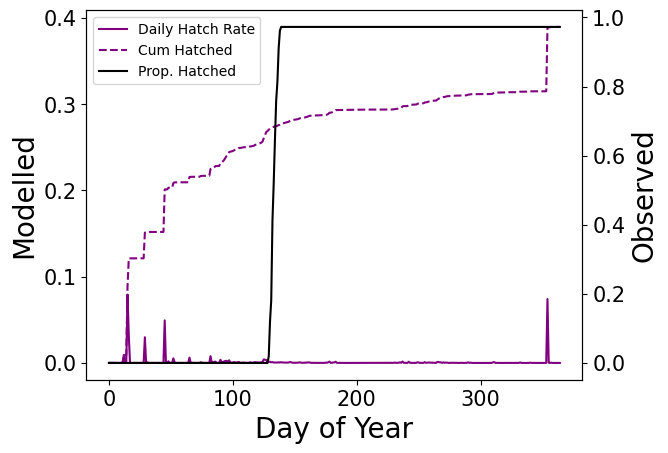

In [12]:
learning_rate = 1e-7
model = SimpleModel()
for i in range(10):
    model.init_pop()
    model.forward(300, 1988, 0, 1990, 365, False)
    plot_match(model)
    model.print_params()
    model.update_params(validation, 1988)


## Running Optimization
First, we use basic gradient descent with a reasonably large learning rate to quickly approach better model. Then, we use Adam to further finetune our optimization.

Loss:  0.2739817499395832


C:\Users\406260\AppData\Local\Temp\ipykernel_12712\2650927171.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loss:  0.2732373531772163
Loss:  0.27247333580208916


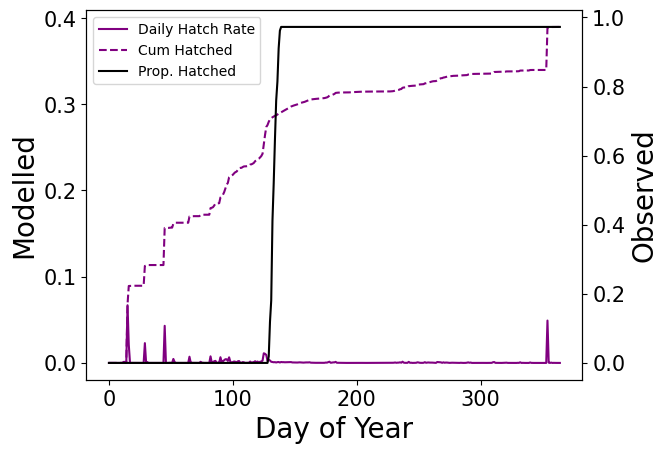

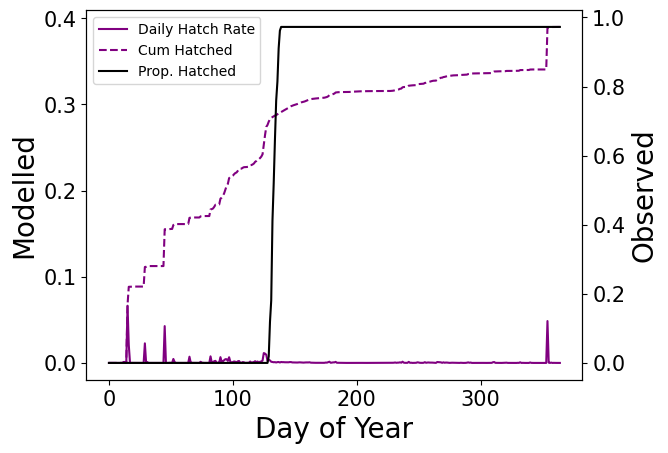

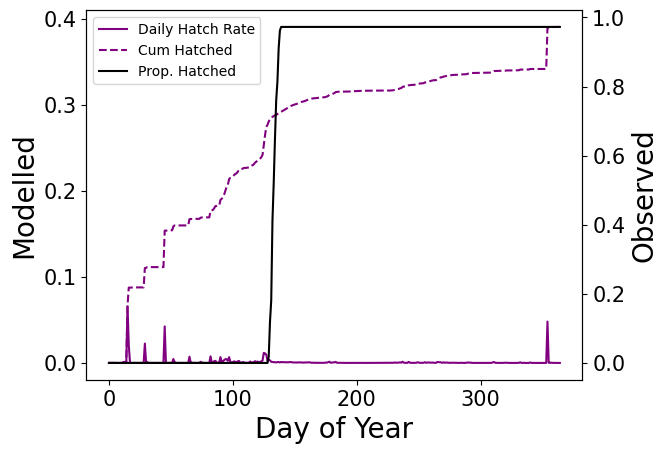

In [8]:
model = SimpleModel()
run_adam(model, 1e-3, 3, validation, 1988, verbose=True)

In [46]:
model.print_params()

Prediapause:  tensor(1.1171, requires_grad=True) tensor(0.)
Diapause I:  tensor(2.1812, requires_grad=True) tensor(0.)
Diapause D:  tensor(2.6221, requires_grad=True) tensor(0.)
Postdiapause:  tensor(1.0977, requires_grad=True) tensor(0.)
First Instar:  tensor(1.1316, requires_grad=True) tensor(0.)
Second Instar:  tensor(1.1528, requires_grad=True) tensor(0.)
Third Instar:  tensor(1.1322, requires_grad=True) tensor(0.)
Fourth Instar:  tensor(1.1366, requires_grad=True) tensor(0.)
Male Late Instar:  tensor(1.1183, requires_grad=True) tensor(0.)
Female Late Instar:  tensor(1.1182, requires_grad=True) tensor(0.)
Male Pupae:  tensor(1.1229, requires_grad=True) tensor(0.)
Female Pupae:  tensor(1.1244, requires_grad=True) tensor(0.)
Adult:  tensor(1.1158, requires_grad=True) tensor(0.)


C:\Users\406260\AppData\Local\Temp\ipykernel_7700\653666994.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tensor(0.5907, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.5692, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.5360, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4887, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4465, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3797, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3278, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3163, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3281, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3536, dtype=torch.float64, grad_fn=<MeanBackward0>)


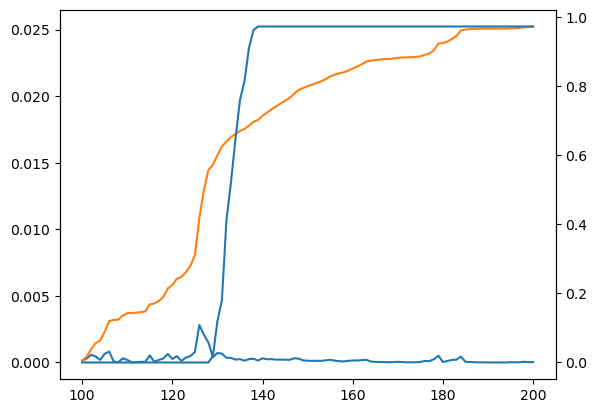

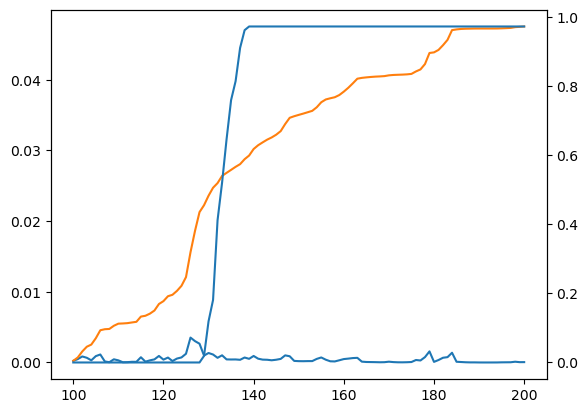

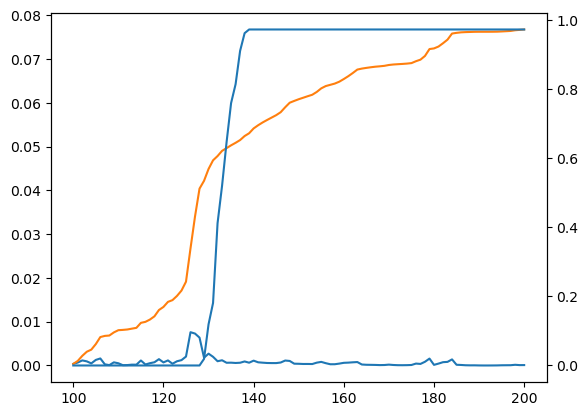

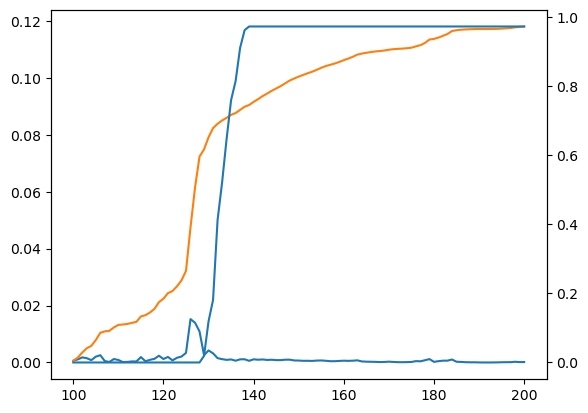

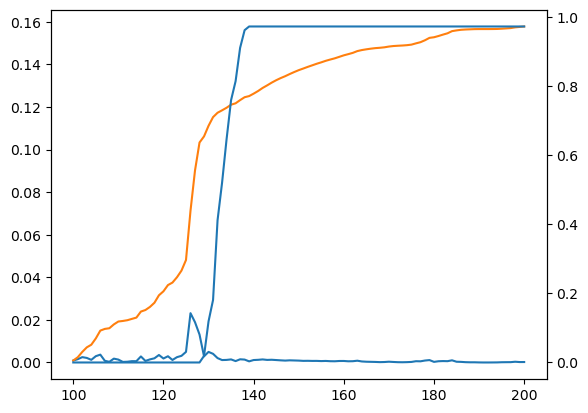

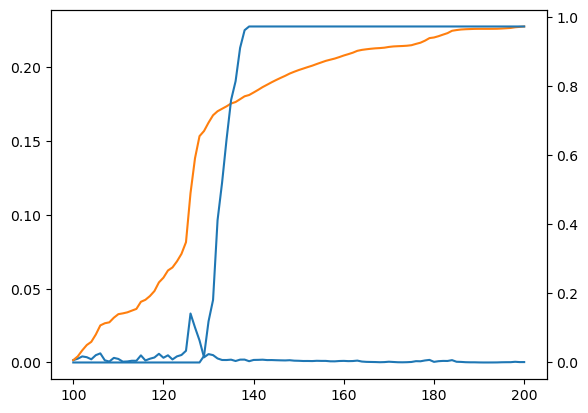

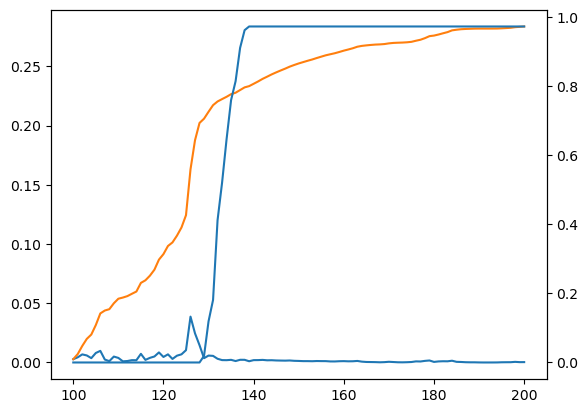

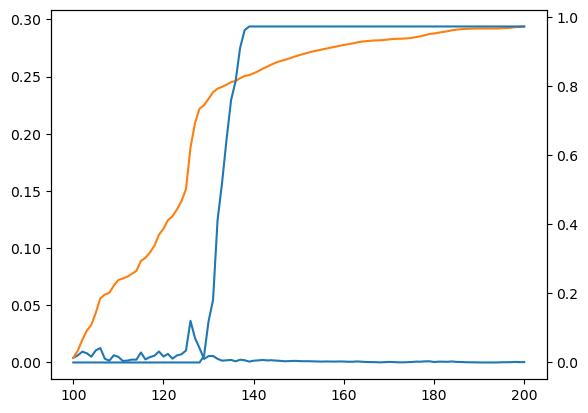

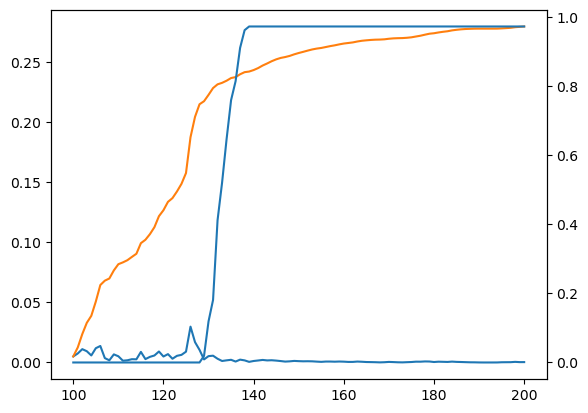

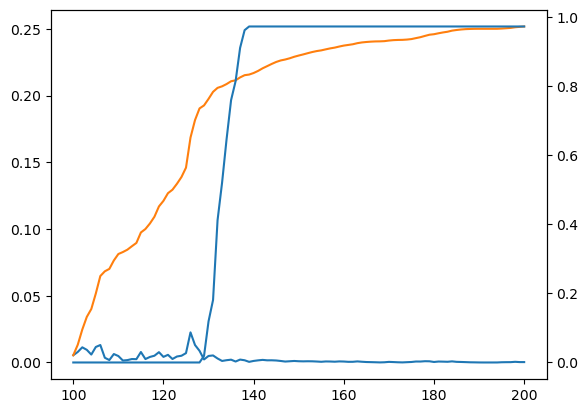

In [75]:
for i in range(10):
    model.init_pop()
    model.forward(300, 1988, 100, 1990, 200, False)
    plot_match(model)
    model.update_params(validation, 1988)